---

#  mplfinance Date iLoc Transform

---

In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import pandas as pd

In [3]:
import mplfinance as mpf
mpf.__version__

'0.12.7a11'

In [4]:
df = pd.read_csv('../data/SP500_NOV2019_Hist.csv',index_col=0,parse_dates=True)

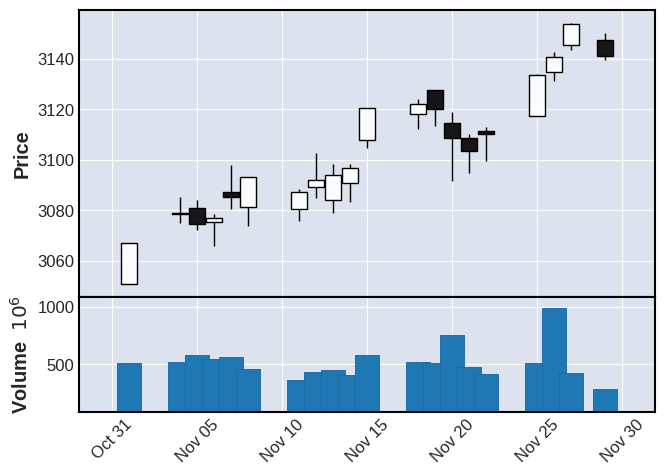

In [5]:
mpf.plot(df,type='candle',show_nontrading=True,volume=True)

In [6]:
%ls -l ../data/*.csv

-rw-r--r-- 1 dino dino  33851 Dec 28 18:30 ../data/SP500_20191106_IDayBollinger.csv
-rw-r--r-- 1 dino dino   1097 Sep 22  2020 ../data/SP500_NOV2019_Hist.csv
-rw-r--r-- 1 dino dino  78853 Sep 22  2020 ../data/SP500_NOV2019_IDay.csv
-rw-r--r-- 1 dino dino  92731 Feb 22 12:34 ../data/SP500_NOV2019_IDayRVol.csv
-rw-r--r-- 1 dino dino  35001 Sep 22  2020 ../data/SPY_20110701_20120630_Bollinger.csv
-rwxr-xr-x 1 dino dino  33235 Sep 22  2020 ../data/jpyusd_barchartdotcom.csv*
-rw-r--r-- 1 dino dino 239788 Sep 22  2020 ../data/yahoofinance-AAPL-20040819-20180120.csv
-rw-r--r-- 1 dino dino 250345 Sep 22  2020 ../data/yahoofinance-GOOG-20040819-20180120.csv
-rw-r--r-- 1 dino dino 161639 Sep 22  2020 ../data/yahoofinance-INTC-19950101-20040412.csv
-rw-r--r-- 1 dino dino 189400 Sep 22  2020 ../data/yahoofinance-SPY-20080101-20180101.csv
-rw-r--r-- 1 dino dino   6953 Mar 22 10:49 ../data/yahoofinance-SPY-20200901-20210113.csv


In [7]:
INPUT = ['../data/SP500_NOV2019_Hist.csv',
         '../data/SP500_NOV2019_IDayRVol.csv',
         '../data/SPY_20110701_20120630_Bollinger.csv',
        ]

In [8]:
for file in INPUT:
    data = pd.read_csv(file,index_col=0,parse_dates=True)
    data.iloc[[0,1,-1],:].style.set_caption(str(data.shape)+' '+file)

,Open,High,Low,Close,Volume
Date,,,,,
2019-11-01 00:00:00,3050.720000,3066.950000,3050.720000,3066.910000,510301237
2019-11-04 00:00:00,3078.960000,3085.200000,3074.870000,3078.270000,524848878
2019-11-29 00:00:00,3147.180000,3150.300000,3139.340000,3140.980000,286602291


,Open,Close,High,Low,Volume
Date,,,,,
2019-11-05 09:30:00,3080.800000,3080.490000,3081.470000,3080.300000,2209795
2019-11-05 09:31:00,3080.330000,3079.360000,3080.330000,3079.150000,1739410
2019-11-08 15:59:00,3091.160000,3092.910000,3092.910000,3090.960000,1023516


,Open,High,Low,Close,Adj Close,Volume,UpperB,LowerB,PercentB
Date,,,,,,,,,
2011-07-01 00:00:00,132.089996,134.100006,131.779999,133.919998,117.161659,202385700,132.373927,125.316073,1.219057
2011-07-05 00:00:00,133.779999,134.080002,133.389999,133.809998,117.065437,165936000,133.254297,124.912703,1.066618
2012-06-29 00:00:00,135.199997,136.270004,134.850006,136.100006,121.598610,212250900,136.721010,128.792993,0.921670


### Here we are going to develop a transform similar to date_to_iloc() with the following features:
- Able to transform both directions
- saves the relavant input data to avoid *some* recalculation
- implementation as a class will enable saving the input data in the transform object.

In [9]:
df = pd.read_csv('../data/SP500_NOV2019_IDayRVol.csv',index_col=0,parse_dates=True)
dtindex = df.index

In [10]:
dtseries = dtindex.to_series()
dtseries['2019-11-08 15:50:01':]

Date
2019-11-08 15:51:00   2019-11-08 15:51:00
2019-11-08 15:52:00   2019-11-08 15:52:00
2019-11-08 15:53:00   2019-11-08 15:53:00
2019-11-08 15:54:00   2019-11-08 15:54:00
2019-11-08 15:55:00   2019-11-08 15:55:00
2019-11-08 15:56:00   2019-11-08 15:56:00
2019-11-08 15:57:00   2019-11-08 15:57:00
2019-11-08 15:58:00   2019-11-08 15:58:00
2019-11-08 15:59:00   2019-11-08 15:59:00
Name: Date, dtype: datetime64[ns]

In [11]:
dtseries.describe(datetime_is_numeric=True)

count                             1563
mean     2019-11-07 00:43:29.596929024
min                2019-11-05 09:30:00
25%                2019-11-06 00:45:00
50%                2019-11-06 16:00:00
75%                2019-11-07 15:59:30
max                2019-11-08 15:59:00
Name: Date, dtype: object

In [50]:
import pandas as pd
import numpy  as np
import matplotlib.dates as mdates
from mplfinance._utils import _date_to_mdate
    
class DateIlocTransform:
    '''Create a transform object that can transform from a date to a DatetimeIndex location, and vis versa.
    Requires a Pandas DatetimeIndex upon creation
    If `date` does not exactly match a date in the series then interpolate between two dates.
    If `date` is outside the range of dates in the series, then extrapolate.
    '''
    
    def __init__(self,dtindex):
        if not isinstance(dtindex,pd.DatetimeIndex):
            raise TypeError('Need `pandas.DatetimeIndex`, but got "'+str(type(dtindex))+'"')
        if not len(dtindex) > 1:
            raise ValueError('`dtindex` must have length of at least 2.')
        self._dtindex  = dtindex
        self._dtseries = dtindex.to_series()
        self._lsslope, self._lsyicpt = self._lsq_linear(self._dtseries)
        self._epslope, self._epyicpt = self._ep_linear(self._dtseries)
        

    def _lsq_linear(self,dtseries):
        '''
        Calculate `y = mx + b` linear relationship between `date` and
        `iloc` in `dtseries`.  Return slope (m) and y_intercept (b).
        This closed-form linear least squares algorithm was taken from
        https://mmas.github.io/least-squares-fitting-numpy-scipy
        '''
        si = dtseries
        s  = si.dropna() 
        if len(s) < 2:
            err = 'NOT enough data for Least Squares'
            if (len(si) > 2):
                err += ', due to presence of NaNs'
            raise ValueError(err)
        xs = mdates.date2num(s.index.to_pydatetime())
        ys = [y for y in range(len(xs))]
        a  = np.vstack([xs, np.ones(len(xs))]).T
        m, b  = np.dot(np.linalg.inv(np.dot(a.T,a)), np.dot(a.T,ys))
        #x1, x2 = xs[0], xs[-1]
        #y1 = m*x1 + b
        #y2 = m*x2 + b
        #x1, x2 = mdates.num2date(x1), mdates.num2date(x2)
        #return ((x1,y1),(x2,y2))
        return m, b
    
    def _ep_linear(self,dtseries):
        d1 = _date_to_mdate(dtseries.index[0])
        d2 = _date_to_mdate(dtseries.index[-1])

        i1 = 0.0
        i2 = len(dtseries) - 1.0

        slope   = (i2 - i1) / (d2 - d1)
        yitrcpt1 = i1 - (slope*d1)
        yitrcpt2 = i2 - (slope*d2)
        if yitrcpt1 != yitrcpt2:
            print('WARNING: yintercepts NOT equal!!!(',yitrcpt1,yitrcpt2,')')
            yitrcpt = (yitrcpt1 + yitrcpt2) / 2.0
        else:
            yitrcpt = yitrcpt1 
        return slope, yitrcpt
    
    def to_iloc(self,date,method='ls'):
        if method == 'ls':   # Least Squares linear
            return self._lsslope*mdates.date2num(date) + self._lsyicpt
        elif method == 'ep': # End Point linear
            return self._epslope*mdates.date2num(date) + self._epyicpt
        elif method == 'in': # INterpolate
            d1s = self._dtseries.loc[date:]
            d1  = d1s[ 0] if len(d1s) > 0 else self._dtseries.iloc[-1]
            d2s = self._dtseries.loc[:date]
            d2  = d2s[-1] if len(d2s) > 0 else self._dtseries.iloc[ 0]
            print('\nd1,d2=',d1.date().day,d2.date().day,' intloc,iloc=',intloc,iloc)
# TODO: Finish Up this CODE BLOCK:
            # If there are duplicate dates in the series, for example in a renko plot
            # then .get_loc(date) will return a slice containing all the dups, so:
            loc1 = dtseries.index.get_loc(d1)
            if isinstance(loc1,slice): loc1 = loc1.start
            loc2 = dtseries.index.get_loc(d2)
            if isinstance(loc2,slice): loc2 = loc2.stop - 1
            return (loc1+loc2)/2.0
        else:
            raise ValueError('Bad value for `method`: ('+str(method)+') ')
        return loc2
    
    def to_datetime(self,iloc,method='ls'):
        '''
        y = mx + b    
        x = (y-b)/m
        '''
        if method == 'ls':    # Least Squares linear
            d = (iloc - self._lsyicpt)/self._lsslope
            return mdates.num2date(d).replace(tzinfo=None)
        elif method == 'ep':  # End Point linear
            d = (iloc - self._epyicpt)/self._epslope
            return mdates.num2date(d).replace(tzinfo=None)
        elif method == 'in': # INterpolate
            intloc = int(np.round(iloc))
            d1s = self._dtseries.iloc[intloc:]
            d1  = d1s[ 0] if len(d1s) > 0 else self._dtseries.iloc[-1]
            d2s = self._dtseries.iloc[:intloc]
            d2  = d2s[-1] if len(d2s) > 0 else self._dtseries.iloc[ 0]
            print('\nd1,d2=',d1.date().day,d2.date().day,' intloc,iloc=',intloc,iloc)
            return d2
        else:
            raise ValueError('Bad value for `method`: ('+str(method)+') ')

In [35]:
df = pd.read_csv('../data/SP500_NOV2019_Hist.csv',index_col=0,parse_dates=True)

In [36]:
dit = DateIlocTransform(df.index)

### Uses for DateIlocTransform

#### All uses are for `show_nontrading=False` only:

- `.to_date()` &nbsp; location *to* date: &nbsp; for tick label formatting.
- `.to_iloc()` &nbsp; date *to* location: &nbsp; for `xticks` placement.
- `.to_iloc()` &nbsp; date *to* location: &nbsp; for `xlim` placement.
- `.to_iloc()` &nbsp; date *to* location: &nbsp; for `lines` placement.

---

- It seems to me that  
  - **interpolation** may be better using the actual datetime series (rather than the linear formula), whereas 
  - **extrapolation** *will require* the linear formula.
  - need to run some tests to see which, if either, is better.
- Keep in mind, while testing, that `xlim` values will affect `xticks` placement.


In [37]:
for method in ['ep','ls']:
    print('\n=== method: "'+method+'"  =====')
    for d in df.index.to_pydatetime():
        il = dit.to_iloc(d,method=method)
        dt = dit.to_datetime(il,method=method)
        err = 'ERR' if d.date().day != dt.date().day else ''
        print("%6.2f  %2d  %2d  %3s" % (il,d.date().day,dt.date().day,err))


=== method: "ep"  =====
  0.00   1   1     
  2.04   4   4     
  2.71   5   5     
  3.39   6   6     
  4.07   7   7     
  4.75   8   8     
  6.79  11  11     
  7.46  12  12     
  8.14  13  13     
  8.82  14  14     
  9.50  15  15     
 11.54  18  18     
 12.21  19  19     
 12.89  20  20     
 13.57  21  21     
 14.25  22  22     
 16.29  25  25     
 16.96  26  26     
 17.64  27  27     
 19.00  29  29     

=== method: "ls"  =====
 -0.46   1   1     
  1.65   4   4     
  2.36   5   5     
  3.06   6   6     
  3.77   7   7     
  4.47   8   8     
  6.58  11  11     
  7.28  12  12     
  7.99  13  13     
  8.69  14  14     
  9.39  15  15     
 11.51  18  18     
 12.21  19  19     
 12.91  20  20     
 13.62  21  21     
 14.32  22  22     
 16.43  25  25     
 17.13  26  26     
 17.84  27  27     
 19.25  29  29     


In [41]:
dtseries = df.index.to_series()

In [46]:
dtseries.iloc[2:][0]
dtseries.iloc[:2][-1]

Timestamp('2019-11-05 00:00:00')

Timestamp('2019-11-04 00:00:00')

In [47]:
dtseries[0:3]

Date
2019-11-01   2019-11-01
2019-11-04   2019-11-04
2019-11-05   2019-11-05
Name: Date, dtype: datetime64[ns]

In [49]:
df.index[0:3]

DatetimeIndex(['2019-11-01', '2019-11-04', '2019-11-05'], dtype='datetime64[ns]', name='Date', freq=None)

In [38]:
for d in df.index.to_pydatetime():
    il = dit.to_iloc(d,method='ls')
    dt = dit.to_datetime(il,method='ils')
    err = 'ERR' if d.date().day != dt.date().day else ''
    print("%6.2f  %2d  %2d  %3s" % (il,d.date().day,dt.date().day,err))


d1,d2= 1 1  intloc,iloc= 0 -0.45703490378218703
 -0.46   1   1     

d1,d2= 5 4  intloc,iloc= 2 1.653997230287132
  1.65   4   4     

d1,d2= 5 4  intloc,iloc= 2 2.3576746083108446
  2.36   5   4  ERR

d1,d2= 6 5  intloc,iloc= 3 3.0613519863327383
  3.06   6   5  ERR

d1,d2= 7 6  intloc,iloc= 4 3.765029364356451
  3.77   7   6  ERR

d1,d2= 7 6  intloc,iloc= 4 4.468706742380164
  4.47   8   6  ERR

d1,d2= 12 11  intloc,iloc= 7 6.579738876449483
  6.58  11  11     

d1,d2= 12 11  intloc,iloc= 7 7.283416254473195
  7.28  12  11  ERR

d1,d2= 13 12  intloc,iloc= 8 7.987093632496908
  7.99  13  12  ERR

d1,d2= 14 13  intloc,iloc= 9 8.690771010518802
  8.69  14  13  ERR

d1,d2= 14 13  intloc,iloc= 9 9.394448388542514
  9.39  15  13  ERR

d1,d2= 19 18  intloc,iloc= 12 11.505480522613652
 11.51  18  18     

d1,d2= 19 18  intloc,iloc= 12 12.209157900635546
 12.21  19  18  ERR

d1,d2= 20 19  intloc,iloc= 13 12.912835278659259
 12.91  20  19  ERR

d1,d2= 21 20  intloc,iloc= 14 13.616512656682971

In [17]:
STOP

NameError: name 'STOP' is not defined

In [21]:
lm, lb = dit._lsq_linear(dtseries)
lm, lb

(396.01924555934966, -7209553.365142822)

In [22]:
em, eb = dit._ep_linear(dtseries)
em, eb

(477.65555319598406, -8695908.417922696)

In [23]:
for jj in range(len(dtseries)):
    date = dtseries.iloc[jj]
    
    ly  = lm*mdates.date2num(date) + lb
    ily = int(np.round(ly))
    
    ey  = em*mdates.date2num(date) + eb
    iey = int(np.round(ey))
    
    print("%2d  %5.2f  %2d  %5.2f %20s" % (ily,ly,iey,ey,date))

134  133.76   0   0.00  2019-11-05 09:30:00
134  134.03   0   0.33  2019-11-05 09:31:00
134  134.31   1   0.66  2019-11-05 09:32:00
135  134.58   1   1.00  2019-11-05 09:33:00
135  134.86   1   1.33  2019-11-05 09:34:00
135  135.13   2   1.66  2019-11-05 09:35:00
135  135.41   2   1.99  2019-11-05 09:36:00
136  135.68   2   2.32  2019-11-05 09:37:00
136  135.96   3   2.65  2019-11-05 09:38:00
136  136.23   3   2.99  2019-11-05 09:39:00
137  136.51   3   3.32  2019-11-05 09:40:00
137  136.78   4   3.65  2019-11-05 09:41:00
137  137.06   4   3.98  2019-11-05 09:42:00
137  137.33   4   4.31  2019-11-05 09:43:00
138  137.61   5   4.64  2019-11-05 09:44:00
138  137.88   5   4.98  2019-11-05 09:45:00
138  138.16   5   5.31  2019-11-05 09:46:00
138  138.43   6   5.64  2019-11-05 09:47:00
139  138.71   6   5.97  2019-11-05 09:48:00
139  138.98   6   6.30  2019-11-05 09:49:00
139  139.26   7   6.63  2019-11-05 09:50:00
140  139.53   7   6.97  2019-11-05 09:51:00
140  139.81   7   7.30  2019-11-

220  219.56  103  103.49  2019-11-05 14:42:00
220  219.84  104  103.82  2019-11-05 14:43:00
220  220.11  104  104.16  2019-11-05 14:44:00
220  220.39  104  104.49  2019-11-05 14:45:00
221  220.66  105  104.82  2019-11-05 14:46:00
221  220.94  105  105.15  2019-11-05 14:47:00
221  221.21  105  105.48  2019-11-05 14:48:00
221  221.49  106  105.81  2019-11-05 14:49:00
222  221.76  106  106.15  2019-11-05 14:50:00
222  222.04  106  106.48  2019-11-05 14:51:00
222  222.31  107  106.81  2019-11-05 14:52:00
223  222.59  107  107.14  2019-11-05 14:53:00
223  222.86  107  107.47  2019-11-05 14:54:00
223  223.14  108  107.80  2019-11-05 14:55:00
223  223.41  108  108.14  2019-11-05 14:56:00
224  223.69  108  108.47  2019-11-05 14:57:00
224  223.96  109  108.80  2019-11-05 14:58:00
224  224.24  109  109.13  2019-11-05 14:59:00
225  224.51  109  109.46  2019-11-05 15:00:00
225  224.79  110  109.79  2019-11-05 15:01:00
225  225.06  110  110.13  2019-11-05 15:02:00
225  225.34  110  110.46  2019-11-

583  583.13  542  542.01  2019-11-06 12:44:00
583  583.40  542  542.34  2019-11-06 12:45:00
584  583.68  543  542.67  2019-11-06 12:46:00
584  583.95  543  543.00  2019-11-06 12:47:00
584  584.23  543  543.33  2019-11-06 12:48:00
585  584.50  544  543.66  2019-11-06 12:49:00
585  584.78  544  544.00  2019-11-06 12:50:00
585  585.05  544  544.33  2019-11-06 12:51:00
585  585.33  545  544.66  2019-11-06 12:52:00
586  585.60  545  544.99  2019-11-06 12:53:00
586  585.88  545  545.32  2019-11-06 12:54:00
586  586.15  546  545.66  2019-11-06 12:55:00
586  586.43  546  545.99  2019-11-06 12:56:00
587  586.70  546  546.32  2019-11-06 12:57:00
587  586.98  547  546.65  2019-11-06 12:58:00
587  587.25  547  546.98  2019-11-06 12:59:00
588  587.53  547  547.31  2019-11-06 13:00:00
588  587.80  548  547.65  2019-11-06 13:01:00
588  588.08  548  547.98  2019-11-06 13:02:00
588  588.35  548  548.31  2019-11-06 13:03:00
589  588.63  549  548.64  2019-11-06 13:04:00
589  588.91  549  548.97  2019-11-

945  945.32  979  978.86  2019-11-07 10:41:00
946  945.60  979  979.19  2019-11-07 10:42:00
946  945.87  980  979.53  2019-11-07 10:43:00
946  946.15  980  979.86  2019-11-07 10:44:00
946  946.42  980  980.19  2019-11-07 10:45:00
947  946.70  981  980.52  2019-11-07 10:46:00
947  946.97  981  980.85  2019-11-07 10:47:00
947  947.25  981  981.18  2019-11-07 10:48:00
948  947.52  982  981.52  2019-11-07 10:49:00
948  947.80  982  981.85  2019-11-07 10:50:00
948  948.07  982  982.18  2019-11-07 10:51:00
948  948.35  983  982.51  2019-11-07 10:52:00
949  948.62  983  982.84  2019-11-07 10:53:00
949  948.90  983  983.17  2019-11-07 10:54:00
949  949.17  984  983.51  2019-11-07 10:55:00
949  949.45  984  983.84  2019-11-07 10:56:00
950  949.72  984  984.17  2019-11-07 10:57:00
950  950.00  985  984.50  2019-11-07 10:58:00
950  950.27  985  984.83  2019-11-07 10:59:00
951  950.55  985  985.16  2019-11-07 11:00:00
951  950.82  985  985.50  2019-11-07 11:01:00
951  951.10  986  985.83  2019-11-

1008  1008.03  1054  1054.49  2019-11-07 14:29:00
1008  1008.30  1055  1054.82  2019-11-07 14:30:00
1009  1008.58  1055  1055.15  2019-11-07 14:31:00
1009  1008.85  1055  1055.49  2019-11-07 14:32:00
1009  1009.13  1056  1055.82  2019-11-07 14:33:00
1009  1009.40  1056  1056.15  2019-11-07 14:34:00
1010  1009.68  1056  1056.48  2019-11-07 14:35:00
1010  1009.95  1057  1056.81  2019-11-07 14:36:00
1010  1010.23  1057  1057.14  2019-11-07 14:37:00
1011  1010.50  1057  1057.48  2019-11-07 14:38:00
1011  1010.78  1058  1057.81  2019-11-07 14:39:00
1011  1011.05  1058  1058.14  2019-11-07 14:40:00
1011  1011.33  1058  1058.47  2019-11-07 14:41:00
1012  1011.60  1059  1058.80  2019-11-07 14:42:00
1012  1011.88  1059  1059.13  2019-11-07 14:43:00
1012  1012.15  1059  1059.47  2019-11-07 14:44:00
1012  1012.43  1060  1059.80  2019-11-07 14:45:00
1013  1012.70  1060  1060.13  2019-11-07 14:46:00
1013  1012.98  1060  1060.46  2019-11-07 14:47:00
1013  1013.25  1061  1060.79  2019-11-07 14:48:00


1377  1377.37  1500  1499.97  2019-11-08 12:52:00
1378  1377.64  1500  1500.30  2019-11-08 12:53:00
1378  1377.92  1501  1500.63  2019-11-08 12:54:00
1378  1378.19  1501  1500.97  2019-11-08 12:55:00
1378  1378.47  1501  1501.30  2019-11-08 12:56:00
1379  1378.74  1502  1501.63  2019-11-08 12:57:00
1379  1379.02  1502  1501.96  2019-11-08 12:58:00
1379  1379.29  1502  1502.29  2019-11-08 12:59:00
1380  1379.57  1503  1502.62  2019-11-08 13:00:00
1380  1379.84  1503  1502.96  2019-11-08 13:01:00
1380  1380.12  1503  1503.29  2019-11-08 13:02:00
1380  1380.39  1504  1503.62  2019-11-08 13:03:00
1381  1380.67  1504  1503.95  2019-11-08 13:04:00
1381  1380.94  1504  1504.28  2019-11-08 13:05:00
1381  1381.22  1505  1504.61  2019-11-08 13:06:00
1381  1381.49  1505  1504.95  2019-11-08 13:07:00
1382  1381.77  1505  1505.28  2019-11-08 13:08:00
1382  1382.04  1506  1505.61  2019-11-08 13:09:00
1382  1382.32  1506  1505.94  2019-11-08 13:10:00
1383  1382.59  1506  1506.27  2019-11-08 13:11:00


In [24]:
alldts = [dtseries[0] + pd.DateOffset(offset) for offset in range(30)]
new_dtseries = pd.Series(alldts,index=pd.DatetimeIndex(alldts))

In [25]:
eerr = []
lerr = []
print("jj ily  iey   ly     ey     dt  dt(il) dt(ie)")
for jj in range(len(new_dtseries)-1):
    date = new_dtseries.iloc[jj]
    
    ly  = lm*mdates.date2num(date) + lb
    ily = int(np.round(ly))
    
    ey  = em*mdates.date2num(date) + eb
    iey = int(np.round(ey))
    
    ily = 0 if (ily < 0 or ily > 19) else ily
    iey = 0 if (iey < 0 or iey > 19) else iey
    
    err_l = dtseries.iloc[ily].date().day - date.date().day
    err_e = dtseries.iloc[iey].date().day - date.date().day
    lerr.append(abs(err_l))
    eerr.append(abs(err_e))

    print("%2d  %2d  %2d  %5.2f  %5.2f  %4s  %4s  %4s  %4s  %4s" % 
          (jj,ily,iey,ly,ey,date.date().day,dtseries.iloc[ily].date().day,
           dtseries.iloc[iey].date().day, err_l, err_e)
         )

print('\nsum(lerr)=',sum(lerr),' sum(eerr)=',sum(eerr))

jj ily  iey   ly     ey     dt  dt(il) dt(ie)
 0   0   0  133.76   0.00     5     5     5     0     0
 1   0   0  529.78  477.66     6     5     5    -1    -1
 2   0   0  925.80  955.31     7     5     5    -2    -2
 3   0   0  1321.82  1432.97     8     5     5    -3    -3
 4   0   0  1717.83  1910.62     9     5     5    -4    -4
 5   0   0  2113.85  2388.28    10     5     5    -5    -5
 6   0   0  2509.87  2865.93    11     5     5    -6    -6
 7   0   0  2905.89  3343.59    12     5     5    -7    -7
 8   0   0  3301.91  3821.24    13     5     5    -8    -8
 9   0   0  3697.93  4298.90    14     5     5    -9    -9
10   0   0  4093.95  4776.56    15     5     5   -10   -10
11   0   0  4489.97  5254.21    16     5     5   -11   -11
12   0   0  4885.99  5731.87    17     5     5   -12   -12
13   0   0  5282.01  6209.52    18     5     5   -13   -13
14   0   0  5678.03  6687.18    19     5     5   -14   -14
15   0   0  6074.05  7164.83    20     5     5   -15   -15
16   0   0  6470.

In [26]:
lerr = []
eerr = []
for jj in range(len(dtseries)):
    date = dtseries.iloc[jj]
    
    ly  = lm*mdates.date2num(date) + lb
    ily = int(np.round(ly))
    
    ey  = em*mdates.date2num(date) + eb
    iey = int(np.round(ey))
    
    err_l = dtseries.iloc[ily].date().day - date.date().day
    err_e = dtseries.iloc[iey].date().day - date.date().day
    
    lerr.append(abs(err_l))
    eerr.append(abs(err_e))

    
    print("%2d  %5.2f  %2d  %5.2f %6s %6s %6s %6s %6s" % (ily,ly,iey,ey,date.date().day,
                                                  dtseries.iloc[ily].date().day,
                                                  dtseries.iloc[iey].date().day,
                                                  err_l, err_e))
    
print('\nsum(lerr)=',sum(lerr),' sum(eerr)=',sum(eerr))

134  133.76   0   0.00      5      5      5      0      0
134  134.03   0   0.33      5      5      5      0      0
134  134.31   1   0.66      5      5      5      0      0
135  134.58   1   1.00      5      5      5      0      0
135  134.86   1   1.33      5      5      5      0      0
135  135.13   2   1.66      5      5      5      0      0
135  135.41   2   1.99      5      5      5      0      0
136  135.68   2   2.32      5      5      5      0      0
136  135.96   3   2.65      5      5      5      0      0
136  136.23   3   2.99      5      5      5      0      0
137  136.51   3   3.32      5      5      5      0      0
137  136.78   4   3.65      5      5      5      0      0
137  137.06   4   3.98      5      5      5      0      0
137  137.33   4   4.31      5      5      5      0      0
138  137.61   5   4.64      5      5      5      0      0
138  137.88   5   4.98      5      5      5      0      0
138  138.16   5   5.31      5      5      5      0      0
138  138.43   

181  180.79  57  56.72      5      5      5      0      0
181  181.06  57  57.05      5      5      5      0      0
181  181.34  57  57.39      5      5      5      0      0
182  181.61  58  57.72      5      5      5      0      0
182  181.89  58  58.05      5      5      5      0      0
182  182.16  58  58.38      5      5      5      0      0
182  182.44  59  58.71      5      5      5      0      0
183  182.71  59  59.04      5      5      5      0      0
183  182.99  59  59.38      5      5      5      0      0
183  183.26  60  59.71      5      5      5      0      0
184  183.54  60  60.04      5      5      5      0      0
184  183.81  60  60.37      5      5      5      0      0
184  184.09  61  60.70      5      5      5      0      0
184  184.36  61  61.03      5      5      5      0      0
185  184.64  61  61.37      5      5      5      0      0
185  184.91  62  61.70      5      5      5      0      0
185  185.19  62  62.03      5      5      5      0      0
185  185.46  6

532  531.98  480  480.31      6      6      6      0      0
532  532.25  481  480.64      6      6      6      0      0
533  532.53  481  480.97      6      6      6      0      0
533  532.80  481  481.30      6      6      6      0      0
533  533.08  482  481.64      6      6      6      0      0
533  533.35  482  481.97      6      6      6      0      0
534  533.63  482  482.30      6      6      6      0      0
534  533.90  483  482.63      6      6      6      0      0
534  534.18  483  482.96      6      6      6      0      0
534  534.45  483  483.29      6      6      6      0      0
535  534.73  484  483.63      6      6      6      0      0
535  535.00  484  483.96      6      6      6      0      0
535  535.28  484  484.29      6      6      6      0      0
536  535.55  485  484.62      6      6      6      0      0
536  535.83  485  484.95      6      6      6      0      0
536  536.10  485  485.28      6      6      6      0      0
536  536.38  486  485.62      6      6  

595  594.96  556  556.27      6      6      6      0      0
595  595.23  557  556.60      6      6      6      0      0
596  595.51  557  556.93      6      6      6      0      0
596  595.78  557  557.26      6      6      6      0      0
596  596.06  558  557.60      6      6      6      0      0
596  596.33  558  557.93      6      6      6      0      0
597  596.61  558  558.26      6      6      6      0      0
597  596.88  559  558.59      6      6      6      0      0
597  597.16  559  558.92      6      6      6      0      0
597  597.43  559  559.26      6      6      6      0      0
598  597.71  560  559.59      6      6      6      0      0
598  597.98  560  559.92      6      6      6      0      0
598  598.26  560  560.25      6      6      6      0      0
599  598.53  561  560.58      6      6      6      0      0
599  598.81  561  560.91      6      6      6      0      0
599  599.08  561  561.25      6      6      6      0      0
599  599.36  562  561.58      6      6  

949  948.62  983  982.84      7      7      7      0      0
949  948.90  983  983.17      7      7      7      0      0
949  949.17  984  983.51      7      7      7      0      0
949  949.45  984  983.84      7      7      7      0      0
950  949.72  984  984.17      7      7      7      0      0
950  950.00  985  984.50      7      7      7      0      0
950  950.27  985  984.83      7      7      7      0      0
951  950.55  985  985.16      7      7      7      0      0
951  950.82  985  985.50      7      7      7      0      0
951  951.10  986  985.83      7      7      7      0      0
951  951.37  986  986.16      7      7      7      0      0
952  951.65  986  986.49      7      7      7      0      0
952  951.92  987  986.82      7      7      7      0      0
952  952.20  987  987.15      7      7      7      0      0
952  952.47  987  987.49      7      7      7      0      0
953  952.75  988  987.82      7      7      7      0      0
953  953.02  988  988.15      7      7  

1012  1012.43  1060  1059.80      7      7      7      0      0
1013  1012.70  1060  1060.13      7      7      7      0      0
1013  1012.98  1060  1060.46      7      7      7      0      0
1013  1013.25  1061  1060.79      7      7      7      0      0
1014  1013.53  1061  1061.13      7      7      7      0      0
1014  1013.80  1061  1061.46      7      7      7      0      0
1014  1014.08  1062  1061.79      7      7      7      0      0
1014  1014.35  1062  1062.12      7      7      7      0      0
1015  1014.63  1062  1062.45      7      7      7      0      0
1015  1014.90  1063  1062.78      7      7      7      0      0
1015  1015.18  1063  1063.12      7      7      7      0      0
1015  1015.45  1063  1063.45      7      7      7      0      0
1016  1015.73  1064  1063.78      7      7      7      0      0
1016  1016.00  1064  1064.11      7      7      7      0      0
1016  1016.28  1064  1064.44      7      7      7      0      0
1017  1016.55  1065  1064.77      7     

1368  1368.29  1489  1489.02      8      8      8      0      0
1369  1368.57  1489  1489.36      8      8      8      0      0
1369  1368.84  1490  1489.69      8      8      8      0      0
1369  1369.12  1490  1490.02      8      8      8      0      0
1369  1369.39  1490  1490.35      8      8      8      0      0
1370  1369.67  1491  1490.68      8      8      8      0      0
1370  1369.94  1491  1491.02      8      8      8      0      0
1370  1370.22  1491  1491.35      8      8      8      0      0
1370  1370.49  1492  1491.68      8      8      8      0      0
1371  1370.77  1492  1492.01      8      8      8      0      0
1371  1371.04  1492  1492.34      8      8      8      0      0
1371  1371.32  1493  1492.67      8      8      8      0      0
1372  1371.59  1493  1493.01      8      8      8      0      0
1372  1371.87  1493  1493.34      8      8      8      0      0
1372  1372.14  1494  1493.67      8      8      8      0      0
1372  1372.42  1494  1494.00      8     

1424  1424.12  1556  1556.36      8      8      8      0      0
1424  1424.40  1557  1556.69      8      8      8      0      0
1425  1424.67  1557  1557.02      8      8      8      0      0
1425  1424.95  1557  1557.36      8      8      8      0      0
1425  1425.22  1558  1557.69      8      8      8      0      0
1425  1425.50  1558  1558.02      8      8      8      0      0
1426  1425.77  1558  1558.35      8      8      8      0      0
1426  1426.05  1559  1558.68      8      8      8      0      0
1426  1426.32  1559  1559.01      8      8      8      0      0
1427  1426.60  1559  1559.35      8      8      8      0      0
1427  1426.87  1560  1559.68      8      8      8      0      0
1427  1427.15  1560  1560.01      8      8      8      0      0
1427  1427.42  1560  1560.34      8      8      8      0      0
1428  1427.70  1561  1560.67      8      8      8      0      0
1428  1427.97  1561  1561.00      8      8      8      0      0
1428  1428.25  1561  1561.34      8     